# Using two spatial weights matrices

Some functions are using spatial weights for two different purposes. Therefore two matrices have to be passed. We will illustrate this case measuring building adjacency and mean interbuilding distance. 

In [1]:
import momepy
import geopandas as gpd
import matplotlib.pyplot as plt

We will again use `osmnx` to get the data for our example and after preprocessing of building layer will generate tessellation. 

In [2]:
import osmnx as ox

gdf = ox.geometries.geometries_from_place('Kahla, Germany', tags={'building':True})
gdf_projected = ox.projection.project_gdf(gdf)

buildings = momepy.preprocess(gdf_projected, size=30,
                              compactness=True, islands=True, verbose=False)
buildings['uID'] = momepy.unique_id(buildings)
limit = momepy.buffered_limit(buildings)
tessellation = momepy.Tessellation(buildings, unique_id='uID', limit=limit,
                                   verbose=False).tessellation

## Building adjacency

Building adjacency is using `spatial_weights_higher` to denote the area within which the calculation occurs (required) and `spatial_weights` to denote adjacency of buildings (optional, the function can do it for us). We can use distance band of 200 meters to define `spatial_weights_higher`.

In [3]:
import libpysal
dist200 = libpysal.weights.DistanceBand.from_dataframe(buildings, 200,
                                                       ids='uID')

In [4]:
adjac = momepy.BuildingAdjacency(
    buildings, spatial_weights_higher=dist200, unique_id='uID')
buildings['adjacency'] = adjac.series

Calculating adjacency: 100%|██████████| 2005/2005 [00:00<00:00, 98379.52it/s]Calculating spatial weights...
Spatial weights ready...



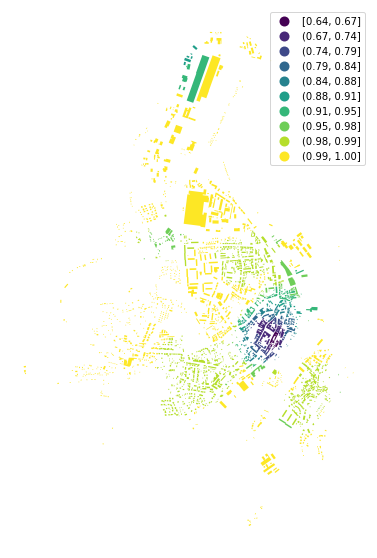

In [5]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(ax=ax, column='adjacency', legend=True, cmap='viridis', scheme='naturalbreaks', k=10)
ax.set_axis_off()
plt.show()

If we want to specify or reuse `spatial_weights`, we can generate them as Queen contiguity weights. Using `libpysal` or `momepy` (momepy will use the same libpysal method, but you don't need to import libpysal directly):

In [6]:
queen = libpysal.weights.Queen.from_dataframe(buildings,
                                              silence_warnings=True,
                                              ids='uID')
queen = momepy.sw_high(k=1, gdf=buildings, ids='uID', contiguity='queen')

In [7]:
buildings['adj2'] = momepy.BuildingAdjacency(buildings,
                                             spatial_weights_higher=dist200,
                                             unique_id='uID',
                                             spatial_weights=queen).series

Calculating adjacency: 100%|██████████| 2005/2005 [00:00<00:00, 86549.47it/s]


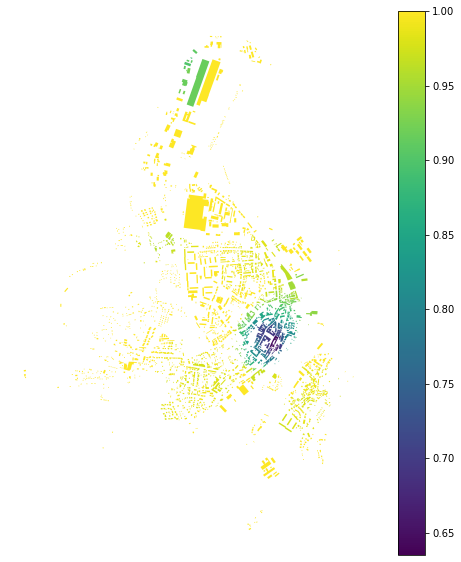

In [8]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(ax=ax, column='adj2', legend=True, cmap='viridis')
ax.set_axis_off()
plt.show()

## Mean interbuilding distance

Mean interbuilding distance is similar to `neighbour_distance`, but it is calculated within vicinity defined in `spatial_weights_higher`, while `spatial_weights` captures immediate neighbours.

In [9]:
sw1 = momepy.sw_high(k=1, gdf=tessellation, ids='uID')
sw3 = momepy.sw_high(k=3, gdf=tessellation, ids='uID')

In [10]:
interblg_distance = momepy.MeanInterbuildingDistance(
    buildings, sw1, 'uID', spatial_weights_higher=sw3)
buildings['mean_ib_dist'] = interblg_distance.series

100%|██████████| 2005/2005 [00:02<00:00, 782.58it/s]


`spatial_weights_higher` is optional and can be derived from `spatial_weights` as weights of higher order defined in `order`.

In [11]:
buildings['mean_ib_dist'] = momepy.MeanInterbuildingDistance(
    buildings, sw1, 'uID', order=3).series

Generating weights matrix (Queen) of 3 topological steps...
100%|██████████| 2005/2005 [00:02<00:00, 820.91it/s]


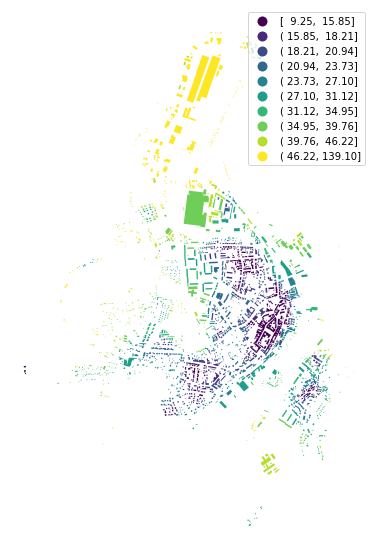

In [12]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(ax=ax, column='mean_ib_dist', scheme='quantiles', k=10, legend=True, cmap='viridis')
ax.set_axis_off()
plt.show()